In [1]:
!git clone https://github.com/openai/point-e.git

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 57 (delta 5), reused 3 (delta 3), pack-reused 39
Unpacking objects: 100% (57/57), done.


In [2]:
%cd point-e/

/content/point-e


In [3]:
pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/point-e
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-uy_pmd0y/clip_613ed591379546f58199c3eaef42483b
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-install-uy_pmd0y/clip_613ed591379546f58199c3eaef42483b
     |████████████████████████████████| 88 kB 7.7 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=4de22239204ea8cddb5c83d17c640b3bb09efd3182c34545e435456f883d2029
  Stored in directory: /tmp/pip-ephem-wheel-cache-14whw8wj/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=0dad6e93d169282330a55f67248771c31d9eb46b277031a5ae9c6d02141ab451
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af

In [4]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|███████████████████████████████████████| 890M/890M [00:16<00:00, 54.9MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/161M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [6]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [8]:
# Set a prompt to condition on.
prompt = 'a green cactus'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

PointCloud(coords=array([[ 0.1870138 ,  0.17928289, -0.2124906 ],
       [-0.10519394, -0.25005394, -0.23749402],
       [-0.3148495 , -0.14533705, -0.42241913],
       ...,
       [-0.06692489,  0.14393659, -0.47459748],
       [-0.12039953, -0.01350794,  0.36599657],
       [ 0.13838142, -0.29381308, -0.30659837]], dtype=float32), channels={'R': array([0.10980393, 0.05882353, 0.07450981, ..., 0.07450981, 0.0627451 ,
       0.06666667], dtype=float32), 'G': array([0.37647063, 0.36078432, 0.3803922 , ..., 0.37647063, 0.3647059 ,
       0.36078432], dtype=float32), 'B': array([0.06666667, 0.01568628, 0.03137255, ..., 0.02352941, 0.01960784,
       0.02745098], dtype=float32)})


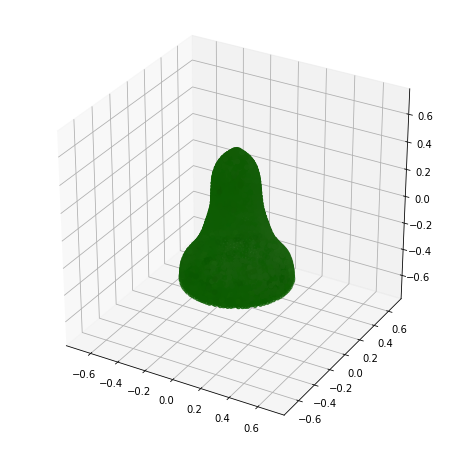

In [10]:
pc = sampler.output_to_point_clouds(samples)[0]
print(pc)
fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))